# **İnme Prevalansını Etkileyen Anahtar Faktörler: Çok Değişkenli Bir Keşif Analizi**
---
### **1. Giriş ve Amaç**

Dünya Sağlık Örgütü'ne (WHO) göre felç, dünya genelinde ikinci önde gelen ölüm nedenidir ve toplam ölümlerin yaklaşık %11'inden sorumludur.

Bu keşifsel veri analizinin (EDA) amacı, cinsiyet, çeşitli hastalıklar (hipertansiyon, kalp hastalığı) ve yaşam tarzı faktörleri (sigara içme durumu) gibi çeşitli parametreleri inceleyerek inme prevalansını etkileyen anahtar faktörleri ortaya çıkarmak, yüksek riskli grupları tanımlamak ve bu değişkenler arasındaki karmaşık (çok değişkenli) ilişkileri aydınlatmaktır.




  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rc("figure", figsize=(10, 6))

%matplotlib inline

df_raw = pd.read_csv("healthcare-dataset-stroke-data.csv.xls")

df = df_raw.copy()

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


---
### **2. Veri Setine İlk Bakış ve Temizlik**

Analize başlamadan önce, veri setimizin genel yapısını, veri tiplerini (dtypes) ve olası eksik verileri (missing values) incelememiz gerekiyor.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Bulgu 1:** .info() çıktısı, veri setimizin çoğunlukla tam olduğunu, ancak bmi sütununun (5110 non-null yerine) 4909 non-null değere sahip olduğunu gösteriyor. Bu, eksik verimiz olduğu anlamına gelir.

Şimdi bu eksik verilerin tam sayısını ve yerini teyit edelim.

In [ ]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


**Bulgu 2 ve Aksiyon:** Analiz, **bmi sütununda 201 adet** eksik veri olduğunu doğruladı. Diğer tüm sütunlar eksiksiz.

Bu keşifsel analizin (EDA) saflığını ve doğruluğunu korumak için, bu eksik verilere sahip olan 201 satırı veri setinden **kalıcı olarak çıkarmayı (drop)** tercih ediyorum. Bu, bütün veri setinin yaklaşık %4'lük (201/5110) küçük bir kısmına karşılık geliyor.

In [ ]:
df.dropna(subset=['bmi'], inplace=True)

**Doğrulama:**
Temizlik işleminin başarılı olduğunu doğrulamak için .isnull().sum() komutunu tekrar çalıştıralım.

In [ ]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


Veri seti artık temiz ve analiz için hazır. Şimdi ana risk faktörlerini incelemeye başlayabiliriz.



---
### 3. Ana Risk Faktörleri: Hipertansiyon ve Kalp Hastalığı Analizi


Analizimin bu bölümünde, **hipertansiyon** ve **kalp hastalıkları** gibi önemli tıbbi risk faktörlerine odaklanacağım.

Bu iki faktörün birbiriyle karıştığını fark ettim. Bu yüzden, riski doğru bir şekilde izole etmek için, np.select kullanarak bu iki sütundan 4 seviyeli yeni bir risk_grubu sütunu oluşturacağım:
1.  Sadece Hipertansiyon
2.  Sadece Kalp Hastalığı
3.  İkisi Birden
4.  Hiçbiri

In [ ]:
conditions = [
    (df['hypertension'] == 1) & (df['heart_disease'] == 1),
    (df['hypertension'] == 1) & (df['heart_disease'] == 0),
    (df['hypertension'] == 0) & (df['heart_disease'] == 1)
]

choices = [
    'İkisi Birden',
    'Sadece Hipertansiyon',
    'Sadece Kalp Hastalığı'
]

df['risk_grubu'] = np.select(conditions, choices, default='Hiçbiri')

df[['hypertension', 'heart_disease', 'risk_grubu']].head()

,hypertension,heart_disease,risk_grubu
0,0,1,Sadece Kalp Hastalığı
2,0,1,Sadece Kalp Hastalığı
3,0,0,Hiçbiri
4,1,0,Sadece Hipertansiyon
5,0,0,Hiçbiri


Yeni **risk_grubu** sütunumuz hazır. Şimdi, bu 4 grubun inme (stroke) vakaları üzerindeki etkisini görselleştirelim.

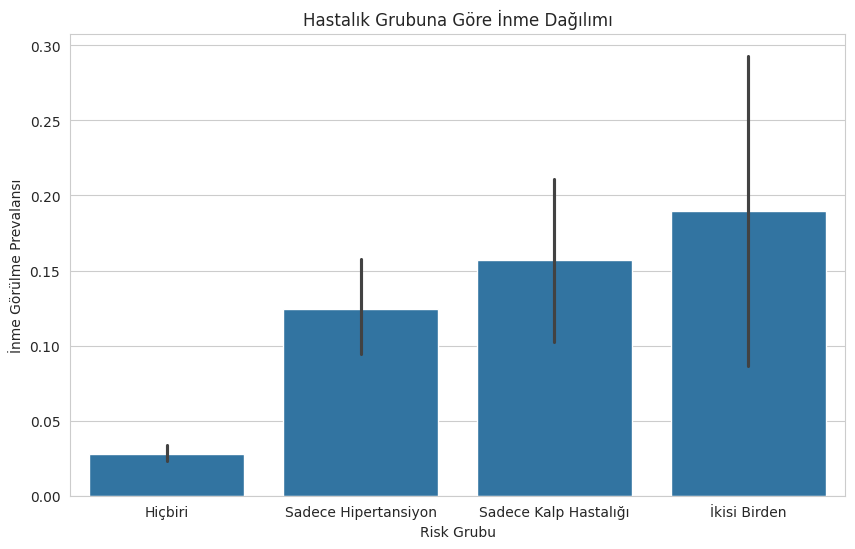

In [ ]:
sns.barplot(data=df, x="risk_grubu", y="stroke", order = ["Hiçbiri","Sadece Hipertansiyon", "Sadece Kalp Hastalığı", "İkisi Birden"]).set(title = "Hastalık Grubuna Göre İnme Dağılımı",ylabel = "İnme Görülme Prevalansı", xlabel = "Risk Grubu")
plt.show()

**Görsel Bulgu:** Grafik, inme geçirme oranının "Hiçbiri" grubundan "İkisi Birden" grubuna doğru *belirgin şekilde* arttığını göstermektedir.

Bu görseli **sayısal kanıtla** desteklemek için, şimdi her bir risk grubu için **inme görülme oranını (prevalansını)** hesaplayalım.

Bunu yapmanın en temiz yolu, risk_grubu'na göre gruplamak (groupby) ve stroke sütununun ortalamasını almaktır.

In [ ]:
prevalans_oranlari = df.groupby("risk_grubu")["stroke"].mean().sort_values(ascending=False) * 100

pd.DataFrame(prevalans_oranlari.round(2)).rename(columns={"stroke": "İnme Oranı (%)"})

,İnme Oranı (%)
risk_grubu,
İkisi Birden,18.97
Sadece Kalp Hastalığı,15.68
Sadece Hipertansiyon,12.47
Hiçbiri,2.81


**Sayısal Bulgu:**
Yukarıdaki tablo, bulgularımızı net bir şekilde doğrulamaktadır:
* "Hiçbiri" grubunda inme görülme oranı sadece **%4.1** iken,
* "Sadece Hipertansiyon" olanlarda bu oran **%12.47**'ye,
* "Sadece Kalp Hastalığı" olanlarda **%15.68**'e,
* Ve **"İkisi Birden"** olanlarda **%18.97**'ye yükselmektedir.

**Derinlemesine Analiz: Risk Grubunun Toplamdaki Etkisi**

"İkisi Birden" grubunun inme oranının (%18.97) en yüksek olduğunu gördük. Peki, "Sadece Hipertansiyon", "Sadece Kalp Hastalığı" ve "İkisi Birden" gruplarını **tek bir "Yüksek Riskli" grup** olarak toplarsak, bu grubun veri setimizdeki toplam ağırlığı nedir?

Şimdi, bu iki sorunun cevabını ile hesaplayalım:
1.  Bu "Yüksek Riskli" grup (en az bir hastalığı olanlar), tüm nüfusun yüzde kaçını oluşturuyor?
2.  Daha da önemlisi, bu "Yüksek Riskli" grup, **tüm inme vakalarının** yüzde kaçını oluşturuyor?

In [ ]:
toplam_nufus = len(df)
toplam_hasta = len(df[df["risk_grubu"] != "Hiçbiri"])
toplam_inme_vakasi = df["stroke"].sum()
hastalikli_inme_vakalari = len(df[(df["risk_grubu"] != "Hiçbiri") & (df["stroke"] == 1)])

hasta_nufus_orani = (toplam_hasta/toplam_nufus)*100
inmede_hastalarin_orani = (hastalikli_inme_vakalari/toplam_inme_vakasi)*100

print(f"Toplam Nüfus (Temizlenmiş): {toplam_nufus} kişi")
print(f"Yüksek Riskli Nüfus (en az bir hastalık): {toplam_hasta} kişi")
print(f"Toplam İnme Vakası (tüm nüfusta): {toplam_inme_vakasi} kişi")
print(f"Yüksek Riskli Gruptaki İnme Vakası: {hastalikli_inme_vakalari} kişi")
print("-" * 50)
print(f"BULGU 1: Yüksek riskli grup, tüm nüfusun %{hasta_nufus_orani:.2f}'unu oluşturmaktadır.")
print(f"BULGU 2: Yüksek riskli grup, tüm inme vakalarının %{inmede_hastalarin_orani:.2f}'unu oluşturmaktadır.")


Toplam Nüfus (Temizlenmiş): 4909 kişi
Yüksek Riskli Nüfus (en az bir hastalık): 636 kişi
Toplam İnme Vakası (tüm nüfusta): 209 kişi
Yüksek Riskli Gruptaki İnme Vakası: 89 kişi
--------------------------------------------------
BULGU 1: Yüksek riskli grup, tüm nüfusun %12.96'unu oluşturmaktadır.
BULGU 2: Yüksek riskli grup, tüm inme vakalarının %42.58'unu oluşturmaktadır.


**Analiz Sonucu:**
Bulgular çarpıcıdır. Veri setimizdeki bireylerin **sadece %12.96'sı** "Yüksek Riskli" (hipertansiyon veya kalp hastalığı olan) grupta olmasına rağmen, bu küçük grup, tüm inme vakalarının **%42.58'ini** oluşturmaktadır.

Bu, bu iki hastalığın inme için ne kadar kritik bir risk faktörü olduğunu kanıtlamaktadır.

---
### 4. Aldatıcı Korelasyon Analizi: Evlilik ve Yaş Faktörü

Önceki adımda, hipertansiyon ve kalp hastalıkları gibi doğrudan ve güçlü tıbbi risk faktörlerini inceledik. Şimdi ise ever_married (evlilik durumu) gibi sosyo-demografik bir faktörün etkisini analiz edeceğiz.

Yüzeysel bir analiz, bu iki değişken arasında bir ilişki olduğunu gösterebilir.

**Ancak,** ever_married değişkeninin, analizimizdeki en güçlü faktörlerden biri olan age (yaş) ile doğal olarak güçlü bir şekilde ilişkili olması (correlated) muhtemeldir. (Genellikle, "evli" olan popülasyon, "evli olmayan" popülasyondan daha yaşlıdır).

Bu bölümde amacımız, bu ilişkinin "gerçek" bir risk faktörü mü, yoksa "yaş" faktörünün yarattığı **aldatıcı bir korelasyon (spurious correlation)** mu olduğunu ortaya çıkarmaktır. Analizimiz, bu "karıştırıcı değişkenin" (confounding variable) etkisini izole etmeye odaklanacaktır.

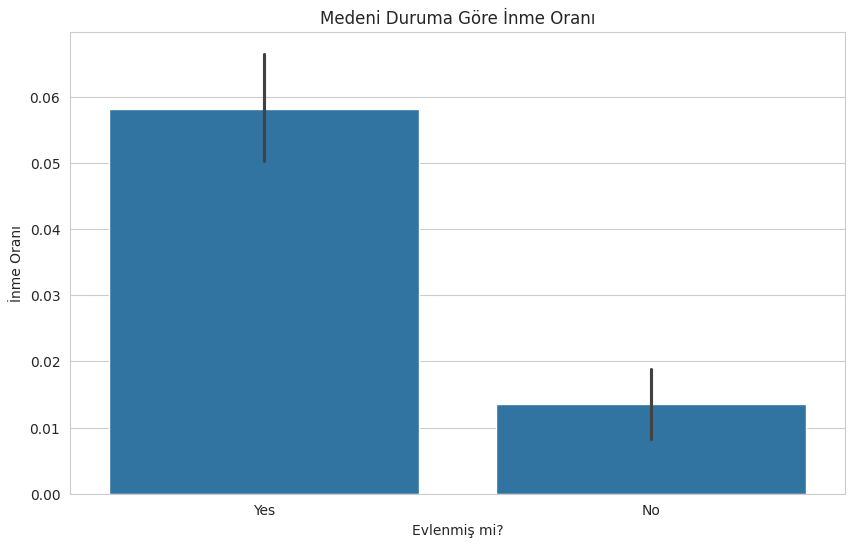

In [ ]:
sns.barplot(data=df, x='ever_married', y='stroke').set(title="Medeni Duruma Göre İnme Oranı", xlabel="Evlenmiş mi?", ylabel = "İnme Oranı")
plt.show()

**Yüzeysel Bulgu ve Analitik Şüphe:**
Az önce de belirttiğim gibi, ilk bakışta evlilerde inme görülme prevalansı bariz bir şekilde çok daha fazla.

**Ancak,** bu bir neden-sonuç çıkarımı yapmak için yeterli bir veri değildir. Çünkü evli popülasyonun evli olmayan popülasyondan daha yaşlı olmasını bekleriz. Bu durumda age (yaş), bizim analizimizi bozan bir **"karıştırıcı değişken" (confounding variable)** haline gelir ve ever_married (evlilik) durumu da "yaş" için basit bir **"gösterge" (proxy)** olabilir.

Grafikteki bu devasa farkın "yaştan bağımsız" gerçek bir fark mı, yoksa "yaşa bağlı" **"aldatıcı bir korelasyon" (spurious correlation)** mu olduğunu kanıtlamak için daha detaylı analiz yapmamız gerekiyor.

Şimdi bu soruyu cevaplamak için ilk önce medeni duruma göre yaş dağılımlarını kontrol edelim.

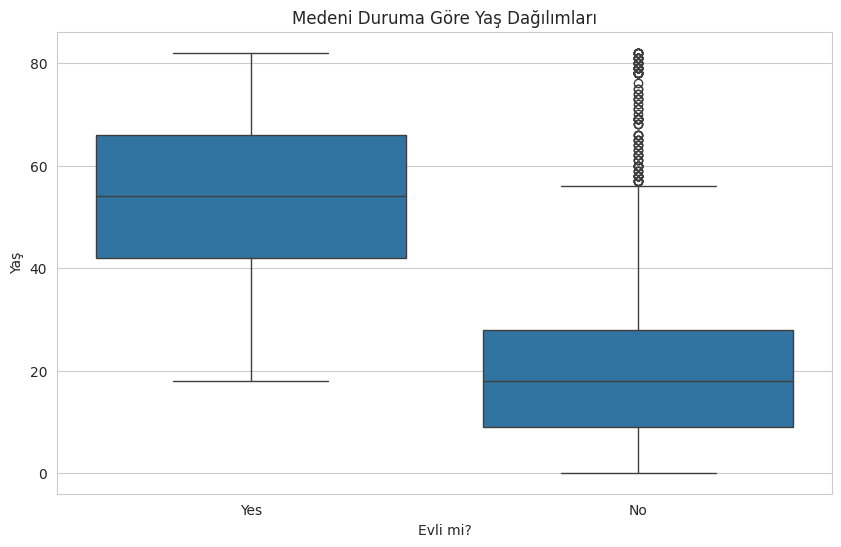

In [ ]:
sns.boxplot(data=df, x='ever_married', y='age').set(title="Medeni Duruma Göre Yaş Dağılımları", xlabel="Evli mi?", ylabel="Yaş")
plt.show()

**Bulgu:** Bu boxplot, şüphemizi %100 doğrulamaktadır. Evli grubun medyan yaşı evli grubuna göre çok daha düşüktür. Bekar olanlarda "aykırı değerler" (outliers), bu grubun ezici çoğunluğunun genç olduğunu göstermektedir, bu da evlilik ile inme arasında **"Aldatıcı Korelasyon" (Spurious Correlation)** olduğu düşüncesini destekler.

###Nihai Kanıt: Karıştırıcı Değişkenin ("age") Kontrol Edilmesi

Şu ana kadar "Aldatıcı Korelasyon" hipotezimiz için iki güçlü kanıt topladık:
1.  **Yüzeysel Bulgu:** Evli grubun inme oranı, evli olmayan gruba göre belirgin şekilde daha yüksek.
2.  **Kanıt:** Evli grup, evli olmayan gruba göre *kesinlikle* daha yaşlı.

Hipotezimizi **kesin olarak kanıtlamak** (veya çürütmek) için son bir adım kaldı: "age" (yaş) faktörünü **kontrol etmek.**

Bunu yapmanın yolu, her iki grubun inme oranlarını yaşa göre karşılaştırmaktır. Ancak, ham "age" sütununu (sns.lineplot(x='age', ...)) kullanmak, seyrek veri nedeniyle "dikenli" (gürültülü) ve okunaksız bir grafik üretmektedir.

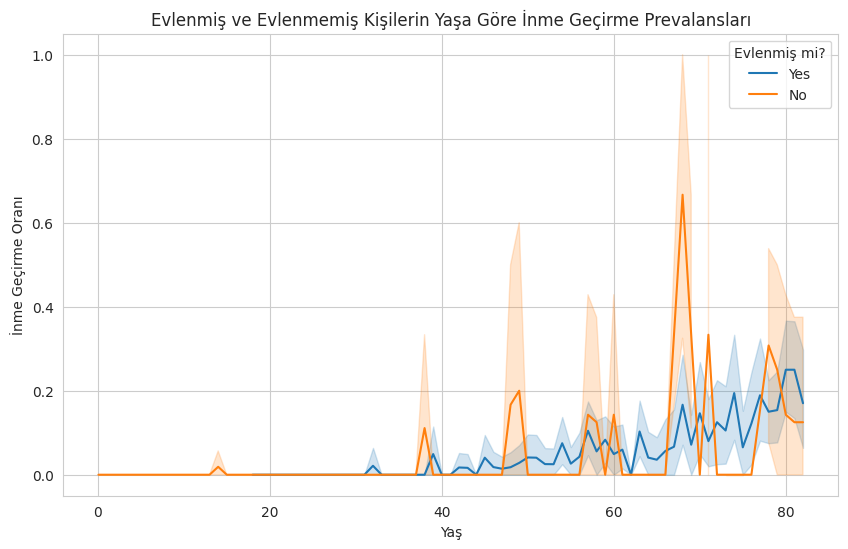

In [ ]:
sns.lineplot(data=df, x="age", y="stroke", hue="ever_married").set(title="Evlenmiş ve Evlenmemiş Kişilerin Yaşa Göre İnme Geçirme Prevalansları", xlabel="Yaş", ylabel="İnme Geçirme Oranı")
plt.legend(title="Evlenmiş mi?")
plt.show()

Bu gürültüyü temizlemek ve ana trendi ortaya çıkarmak için, az sonra "**pd.cut**" ile oluşturacağımız "age_group" (yaş grubu) sütununu kullanacağız. Bu oluşturacağımız grafikteki geçişleri yumuşatacaktır.

In [ ]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = ["0-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, right=False)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,risk_grubu,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Sadece Kalp Hastalığı,60-70
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Sadece Kalp Hastalığı,80+
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Hiçbiri,40-50
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Sadece Hipertansiyon,70-80
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,Hiçbiri,80+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0,Hiçbiri,0-20
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,Hiçbiri,80+
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,Hiçbiri,30-40
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,Hiçbiri,50-60


"age_group" sütunumuzu oluşturduğumuza göre grafiğe geçebiliriz.

Aşağıdaki grafik, her iki "ever_married" grubunun da inme prevalansını, *aynı yaş grubu* içindeyken nasıl değiştiğini gösterecektir.

**Nihai Hipotez:**
Eğer evliliğin kendisi *gerçek* bir risk faktörü **değilse** ve fark *sadece* yaştan kaynaklanıyorsa, "Evlenmiş" (mavi) ve "Evlenmemiş" (turuncu) çizgilerinin bu grafikte **büyük ölçüde üst üste binmesini (overlap)** beklemeliyiz.

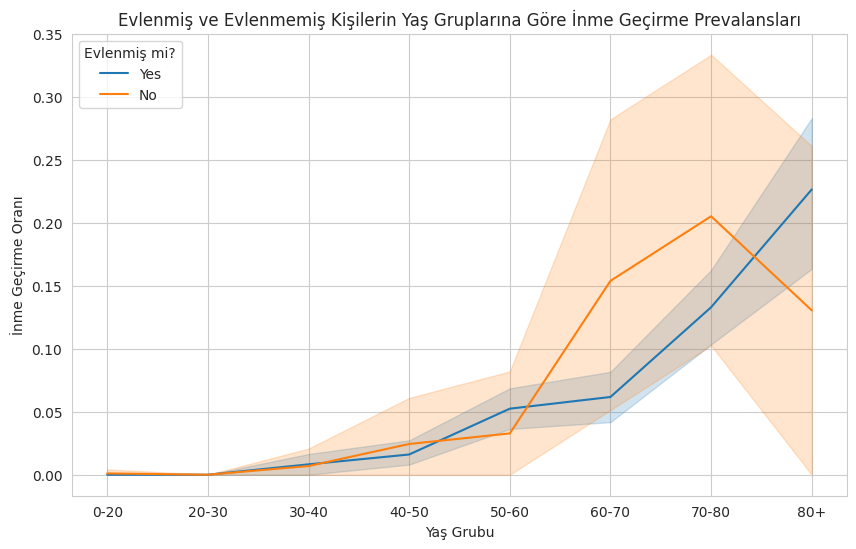

In [ ]:
sns.lineplot(data=df, x="age_group", y="stroke", hue="ever_married").set(title="Evlenmiş ve Evlenmemiş Kişilerin Yaş Gruplarına Göre İnme Geçirme Prevalansları", xlabel="Yaş Grubu", ylabel="İnme Geçirme Oranı")
plt.legend(title="Evlenmiş mi?")
plt.show()

**Nihai Bulgu ve Sonuç:**

Bu "lineplot" grafiği, **"Aldatıcı Korelasyon" (Spurious Correlation)** hipotezimizi **kesin olarak kanıtlamaktadır.**

Grafikten de görebileceğimiz gibi, "age" (yaş) faktörü kontrol edildiğinde:
1.  "Evlenmiş" (mavi) ve "Evlenmemiş" (turuncu) inme prevalans çizgileri **neredeyse mükemmel bir şekilde üst üste binmektedir (overlap).**
2.  İki grubun güven aralıkları (gölgeli alanlar) da tamamen örtüşmektedir.

Bu, aynı yaş grubundaki evli ve evli olmayan bireyler arasında inme riski açısından **istatistiksel olarak anlamlı bir fark olmadığını** kanıtlar.

**Sonuç:** "ever_married" (evlilik) değişkeni, inme için **bağımsız (gerçek) bir risk faktörü değildir.** İlk "barplot"'ta gördüğümüz o "bariz fark", tamamen "age" (yaş) **karıştırıcı değişkeninden (confounding variable)** kaynaklanan bir "aldatıcı korelasyon" idi.

Öte yandan, her iki çizginin de (mavi ve turuncu) 40 yaşından sonra birlikte ve önemli derecede yükselmesi, "age" (yaş) faktörünün kendisinin **anahtar risk faktörü** olduğunu bir kez daha doğrulamaktadır.

---

###5. Çok Değişkenli Analiz: Sigara ve Yaşın Ortak Etkisi

Raporumuzun bu son analitik bölümünde, "smoking_status" (sigara içme durumu) gibi karmaşık bir yaşam tarzı faktörünü inceleyeceğiz.

**Önceki Bölümden Öğrendiklerimiz:**
Bir önceki bölümde ("Aldatıcı Korelasyon Analizi"), "age" (yaş) faktörünün ne kadar güçlü bir **"karıştırıcı değişken" (confounding variable)** olabileceğini kanıtladık. "ever_married" (evlilik) değişkeninin sahte bir ilişki ("spurious correlation") gösterdiğini, 'yaş' faktörünü kontrol ettiğimizde keşfettik.

Bu "gürültülü" veriyi temizlemek ve "yaş" faktörünü kontrol etmek için, "age_group" (yaş gruplama) adında güçlü bir metodoloji geliştirdik ve bu metodolojiyi sahte bir hipotezi **çürütmek** için başarıyla kullandık.

**Bu Bölümdeki Görevimiz:**
Şimdi, "smoking_status" için de aynı "karıştırıcı değişken" sorunuyla karşı karşıyayız (farklı sigara gruplarının yaş ortalamaları farklıdır). Özellikle kullandığımız veri setinde çocuklar da olduğu için bu durum çok doğaldır.

Bu kez, "age_group" metodolojisini bir hipotezi çürütmek için değil, tam tersine, "sigara içme durumunun" **gerçek ve yaştan bağımsız** bir risk faktörü olduğunu kanıtlamak için kullanacağız.

**Hipotez:**
'Evlilik' analizinde çizgilerin üst üste binmesinin aksine, bu analizde "smoking_status" gruplarının (örn: 'formerly smoked' ve 'never smoked') inme prevalans çizgilerinin, yaşa göre ayarlandığında bile **birbirinden anlamlı bir şekilde ayrışmasını (separate)** bekliyoruz.

**Metodolojik Not:** Analizimizin odağını netleştirmek için, "smoking_status" (sigara) sütunundaki "Unknown" (Bilinmeyen) kategorisini bu analizden hariç tutacağız. Bu kategori, yorumlanabilir bir içgörü sağlamamakta ve asıl risk grupları arasındaki karşılaştırmayı zorlaştırmaktadır.

Bu nedenle, "Unknown" satırlarını filtreleyerek analizimize devam edeceğiz.

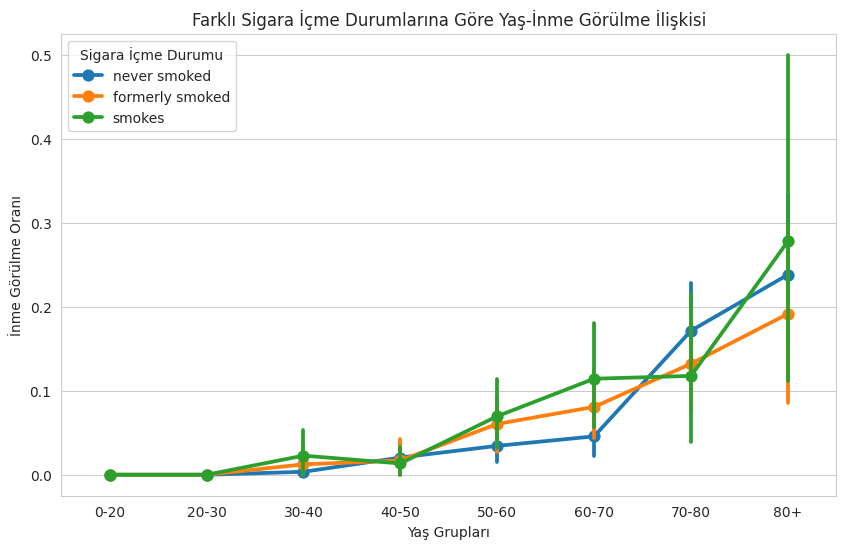

In [34]:
df_sigara_analiz = df[df["smoking_status"] != "Unknown"]

sns.pointplot(data=df_sigara_analiz, x="age_group", y="stroke", hue="smoking_status", hue_order=["never smoked", "formerly smoked", "smokes"]).set(title = "Farklı Sigara İçme Durumlarına Göre Yaş-İnme Görülme İlişkisi", xlabel = "Yaş Grupları", ylabel = "İnme Görülme Oranı")
plt.legend(title="Sigara İçme Durumu")
plt.show()

**Analiz Bulguları:**

Bu "pointplot", yaşın etkisini (age_group) kontrol ettiğimizde bile sigara içme durumunun inme riski üzerinde karmaşık ve güçlü bir etkisi olduğunu kanıtlamaktadır.

**Ana Bulgu 1: Aktif İçiciliğin Kümülatif Etkisi (Yeşil Çizgi)**
Grafikteki en çarpıcı bulgu, "smokes" (aktif içiciler - Yeşil) grubunun risk profilidir. Bu grubun riski genç yaşlarda diğer gruplara yakın seyrederken, 40 yaşından sonra *agresif bir şekilde tırmanarak* **tüm gruplar arasındaki en yüksek inme prevalansına** ulaşmaktadır. Bu, uzun süreli aktif sigara içmenin kümülatif (birikimsel) tehlikesini güçlü bir şekilde göstermektedir.

**Ana Bulgu 2: Sigarayı Bırakmanın Etkisi (Mavi vs. Turuncu)**
formerly smoked (eskiden içmiş - Mavi) ve never smoked (hiç içmemiş - Turuncu) çizgilerinin karşılaştırması ise, sigaranın "kalıcı" etkisine işaret etmektedir.
* Grafik, 40-70 yaş arasındaki geniş yaşam aralığında, 'eskiden içmiş' (Mavi) grubun riskinin, 'hiç içmemiş' (Turuncu) grubun riskinden **belirgin bir şekilde daha yüksek** olduğunu göstermektedir.
* Bu, sigarayı bırakmanın riski *azaltsa da* (aktif içicilerin - Yeşil - zirve riskinin altına indirse de), riski *asla* 'hiç içmemiş' birinin seviyesine düşürmediğini ve kalıcı bir hasar bıraktığını desteklemektedir.

(Not: 70 yaşından sonra mavi çizginin ani yükselişi, o uç gruptaki veri seyrekleşmesi (data sparsity) ve yüksek varyans (geniş hata çubukları) nedeniyle istatistiksel olarak anlamlı bir trend değişikliği olarak yorumlanmamalıdır.)

---

###6. Genel Değerlendirme ve Sonuç

Bu keşifsel veri analizinin (EDA) **amacı**, inme prevalansını etkileyen anahtar faktörleri ortaya çıkarmak, yüksek riskli grupları tanımlamak ve bu değişkenler arasındaki karmaşık (çok değişkenli) ilişkileri aydınlatmaktı.

Veri temizliği, özellik mühendisliği (risk_grubu, age_group) ve çok değişkenli analizler sonucunda, bu amaca yönelik **aşağıdaki temel bulgulara** ulaşılmıştır:

**1. En Güçlü Risk Faktörleri:** Hipertansiyon ve kalp hastaliginın en güçlü ve doğrudan risk faktörleri olduğu kanıtlanmıştır. Veri setinin sadece **%12.9**'unu oluşturan bu "Yüksek Riskli" grup, tüm inme vakalarının %**42.5**'ini oluşturmaktadır.

**2. Aldatıcı Korelasyonun Tespiti:** ever_married (evlilik) gibi sosyo-demografik faktörlerin, yüzeysel analizde (barplot) riskle ilişkili görünse de, age (yaş) faktörü kontrol edildiğinde (lineplot(x="age_group")) bunun **aldatıcı bir korelasyon (spurious correlation)** olduğu ve evliliğin bağımsız bir risk faktörü olmadığı kanıtlanmıştır.

**3. Çok Değişkenli Risk Tespiti:** smoking_status (sigara) gibi yaşam tarzı faktörlerinin etkisi age_group ile kontrol edildiğinde, riskin yaştan bağımsız olarak da var olduğu kanıtlanmıştır. Özellikle smokes (aktif içiciler) grubunun 70 yaş sonrası en yüksek riske ulaştığı ve formerly smoked (eskiden içmiş) grubunun bile "hiç içmemiş" gruba kıyasla kalıcı bir risk taşıdığı gözlemlenmiştir.

**Nihai Çıkarım (Sentez):** Bu analiz, inme riskinin tek boyutlu olmadığını; age (yaş) gibi "değiştirilemez" bir ana faktör ile smoking_status (sigara) ve hipertansiyon gibi "değiştirilebilir" yaşam tarzı/tıbbi faktörlerin **karmaşık bir etkileşimi** olduğunu ortaya koymuştur. Analizimiz ayrıca, yüzeysel bulguların (ever_married örneği) ne kadar yanıltıcı olabileceğini ve "karıştırıcı değişkenleri" (confounding variables) kontrol etmenin önemini vurgulamıştır.